# TopoCluster Regression: ResNet

This is a simple, stripped-down notebook for training networks. I've removed most of the models that are present in `TopoClusterRegressionRewrite.ipynb`, as well as most of the plots (I find that the multitude of plots makes things a bit cumbersome and hard to navigate -- I'll see if I can change the way they are displayed later on).

Here, we just train the so-called `all` model, which uses images from all $6$ calo layers. We train two versions, for charged and neutral pions.

#### 1) Initial setup

In [1]:
# ML fitting/loading/saving settings
overwriteModel = True # If true, force training. If false, load the specified model if it already exists.

Now let's choose our training data (and associated strategy).

In [2]:
# training data choice
# options are jet, pion, pion_reweighted
strat = 'pion'

In [3]:
# Import some basic libraries.
import sys, os, uuid, glob, pickle, pathlib
import numpy as np
import pandas as pd # we will use some uproot/pandas interplay here.
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt # used for plotting
import joblib as jl # for saving scalers
from numba import jit

# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util       as pu
from util import ml_util         as mu
from util import qol_util        as qu
from util import io_util         as iu

# Custom tensorflow.keras callbacks
from util.keras import clr

rt.gStyle.SetOptStat(0)
# use our custom dark style for plots
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle() # still need to manually adjust legends, paves

plotpath = path_prefix + 'regression/Plots/'
modelpath = path_prefix + 'regression/Models/'
paths = [plotpath, modelpath]
for path in paths:
    try: os.makedirs(plotpath)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.22/02


#### 2) Get the data.

Let me lay out some definitions, so it's clear as to what the data is.

We have a number of different "strategies" (the `strat` variable at the top). These correspond to different choices of training, validation and testing datasets.

1. `pion`: We train and validate the network using our pion gun data.

2. `pion_reweighted`: This is the same as `pion`, except that our training data is reweighted using a jet dataset (via their reco topo-cluster $p_T$ distributions), that corresponds with QCD dijet events.

3. `jet`: We train and validate the network using our jet data. This is a facsimile dataset -- we do not know the actual labels of the jet data topo-clusters, so we have assigned labels by matching clusters to truth-level pions in $(\eta,\phi)$.

The validation performed for these networks is effectively being done on some "holdout" dataset from training -- it will by definition have similar kinematics, being drawn from the same set of events. The more interesting test -- how our energy regression performs in tandem with classification on our *unlabeled* jet dataset, will be handled in a separate notebook.

In [4]:
# now determine which files we get training and validation data from. Depends on our strategy.
if(strat == 'pion' or strat == 'pion_reweighted'):
    data_dir = path_prefix + 'data/pion/'
    data_filenames = {'pp':data_dir+'piplus.root','pm':data_dir+'piminus.root','p0':data_dir+'pi0.root'}
    
elif(strat == 'jet'):
    data_dir = path_prefix + 'jets/training/'
    data_filenames = {'pp':data_dir+'piplus.root','p0':data_dir+'pi0.root'}

# adjust our model and plot paths, so that they are unique for each strategy
paths = [modelpath, plotpath]
for i in range(len(paths)):
    path = paths[i]
    path = path + strat
    try: os.makedirs(path)
    except: pass
    path = path + '/'
    paths[i] = path
modelpath, plotpath = paths

# we get uproot trees and pandas DataFrames,
# for training + validation
tree_name = 'ClusterTree'
branches = ['truthE', 'clusterE', 'clusterPt', 'clusterEta', 'cluster_ENG_CALIB_TOT']

data_trees = {key:ur.open(val)[tree_name] for key,val in data_filenames.items()}
data_frames = {key:val.pandas.df(branches,flatten=False) for key,val in data_trees.items()}

#### Preparing training, validation and testing samples

Here, we're going to arrange our dataset into training, validation and testing samples (by defining the indices of these categories).


As we're taking logarithms  of `clusterE` and `cluster_ENG_CALIB_TOT`, we will always perform cuts to have `clusterE` > 0 for all datasets, and `cluster_ENG_CALIB_TOT` > 0 for training. 

On top of those cuts, we're free to apply additional cuts to training, validation and testing data. We can do them below, as we pick event indices for each dataset.

Since we treat $\pi^+$ and $\pi^-$ as the same, let's combine them so that we have *charged* and *neutral* pions. We will store all the charged pions under the key `pp`, and delete the key `pm`.

In [5]:
key_conversion = {'pp':'charged pion','p0':'neutral pion'}
# combining dataframes
if('pm' in data_frames.keys()):
    data_frames['pp'] = data_frames['pp'].append(data_frames['pm'])
    del data_frames['pm']
    
    data_trees['pp'] = [data_trees['pp'],data_trees['pm']]
    data_trees['p0'] = [data_trees['p0']]
    del data_trees['pm']

In [6]:
training_frames = {}
validation_frames = {}

# First, the minimum energy cut that we will always apply to data. Anything that fails to pass this cut will be discarded,
# we will never evaluate on events that don't pass this cut.
global_energy_cut = -1.0e2

# We can apply a lower cut on cluster_ENG_CALIB_TOT, as very low-energy clusters can throw off training.
energy_cut = [0., -1.]
if(strat == 'pion' or strat == 'pion_reweighted'): 
    energy_cut[0] = -1.0e2 # GeV (e.g. 5.0e-1 by default)
    energy_cut[1] = -1.# -1. (make negative for no upper cut)
    
elif(strat == 'jet'): 
    energy_cut[0] = 5.0e-2 # GeV
    energy_cut[1] = -1.

data_indices = {} # indices of all usable data, i.e. non-zero energy
training_indices = {} # indices of events actually used for training
validation_indices = {} # indices of events not used for training (but usable)

# percent of events to hand over from training to testing
testing_frac = 0.2
rng = np.random.default_rng() # for shuffling indices when splitting training/testing
for key in data_frames.keys():
    n = len(data_frames[key])
    eng_calib_tot = data_frames[key]['cluster_ENG_CALIB_TOT'].to_numpy()
    selected_indices = eng_calib_tot > energy_cut[0]
    if(energy_cut[1] > 0.): selected_indices = selected_indices * (eng_calib_tot < energy_cut[1])
    
    selected_indices = selected_indices.nonzero()[0] # from boolean array to a list of actual indices
    rng.shuffle(selected_indices)
    n_test = int(testing_frac * len(selected_indices))
    
    # making boolean arrays to select events -- arrays are of same length as dataframe
    validation_indices[key] = np.full(n,False)
    training_indices[key] = np.full(n,False)
    validation_indices[key][np.sort(selected_indices[:n_test])] = True
    training_indices[key][np.sort(selected_indices[n_test:])] = True

    data_indices[key] = (data_frames[key]['cluster_ENG_CALIB_TOT'] > global_energy_cut).to_numpy()
    data_frames[key] = data_frames[key][data_indices[key]]

In [7]:
for key in data_frames.keys():
    print('Number of {type} training/testing events: {val1}/{val2}'.format(type=key_conversion[key], val1 = np.sum(training_indices[key]), val2 = np.sum(validation_indices[key])))

Number of charged pion training/testing events: 699001/174750
Number of neutral pion training/testing events: 211334/52833


Note that we have many more charged pions than neutral pions, so this *may* result in our charged pion regression being better-trained (unless the stats for both are sufficiently high).

### Defining regression variables

Beyond the information already present in the data, we may want to pre-compute some extra regression inputs.

The difference between computing them here, on the whole dataset, versus doing it in batch as part of the network itself, is that we can also define some `scalers` based on these variables. This will allow us to scale them across the dataset, for example to get them into the interval of \[0,1\].

In [8]:
m = 1.
b = 1.
EnergyMapping = iu.LinLogMapping(b=b,m=m)

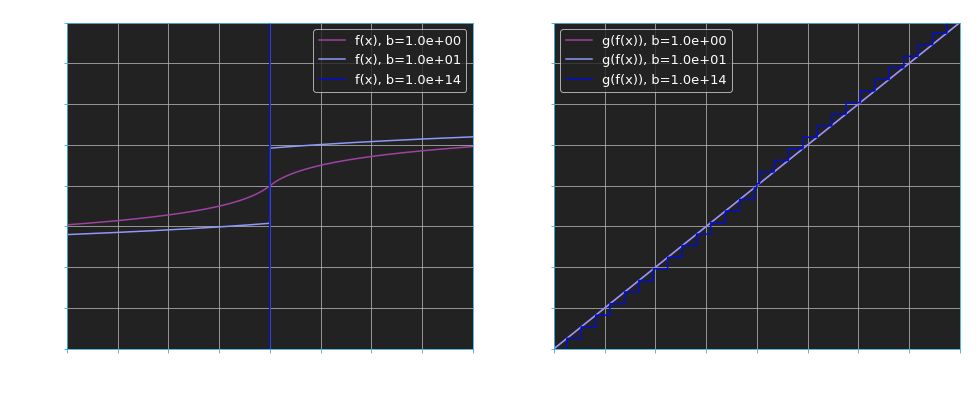

In [9]:
# Perform a test of our mapping to demonstrate its numerical stability
# TODO: Fix legend sizing, it is flaky (and needs re-running)
x=np.linspace(-10.,10.,10000)
b_vals=[1.,10.,1.0e14]
m_vals=[1.]
iu.MapStabilityTest(iu.LogMapping, b_vals=b_vals, m_vals=m_vals, x=x, ps=plotstyle, savedir=plotpath, legend_size=10)

It looks like our `LinLogMapping` is pretty numerically stable as long as $b \gg m$. I think this is the expected behaviour, given the instabilities with logarithms that we've seen before.

In [10]:
# Some regression vars.
# Note that the mapping functions can probably be sped up with numba, but might throw errors during plotting above. Need to look into this.
for key,frame in data_frames.items():
    frame['logE'] = EnergyMapping.Forward(frame['clusterE'].to_numpy())
    frame['logECalib'] = EnergyMapping.Forward(frame['cluster_ENG_CALIB_TOT'].to_numpy())

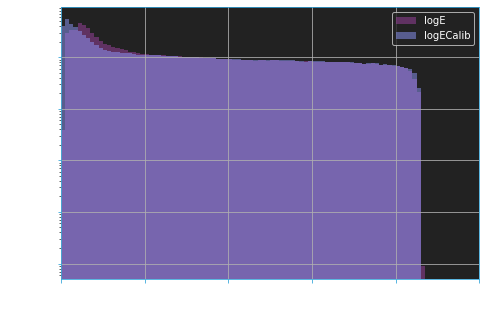

In [11]:
# Let's make a histogram of the regression vars, before scaling.
fig, ax = plt.subplots(1,1,figsize=(7.5,5))
labels = ['logE','logECalib']
rvars = [np.concatenate([frame[x].to_numpy() for frame in data_frames.values()]) for x in labels]

pu.histogramOverlay(ax, rvars, labels, 'x', 'y',
                 x_min = 0., x_max = 10., xbins = 100,
                 normed = True, y_log = True,
                 ps = qu.PlotStyle('dark')
                )
plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler
scaler_file = modelpath + 'scalers.save'

# load/create scalers
if(pathlib.Path(scaler_file).exists()):
    # Fetch the scalers associated with the regression models
    scalers = jl.load(scaler_file)
    scaler_e = scalers['e']
    scaler_cal = scalers['cal']
    scaler_eta = scalers['eta']

else:
    scaler_e = {key:StandardScaler() for key in data_frames.keys()}
    scaler_cal = {key:StandardScaler() for key in data_frames.keys()}
    scaler_eta = {key:StandardScaler() for key in data_frames.keys()}

    # fit our scalers, using the training data
    for key, frame in data_frames.items():
        scaler_e[key].fit(frame['logE'][training_indices[key]].to_numpy().reshape(-1,1))
        scaler_cal[key].fit(frame['logECalib'][training_indices[key]].to_numpy().reshape(-1,1))
        scaler_eta[key].fit(np.abs(frame['clusterEta'][training_indices[key]].to_numpy()).reshape(-1,1))

# apply the scalers to all data
for key, frame in data_frames.items():
    frame['s_logE'] = scaler_e[key].transform(frame['logE'].to_numpy().reshape(-1,1))
    frame['s_logECalib'] = scaler_cal[key].transform(frame['logECalib'].to_numpy().reshape(-1,1))
    frame['s_eta'] = scaler_eta[key].transform(np.abs(frame['clusterEta'].to_numpy()).reshape(-1,1))

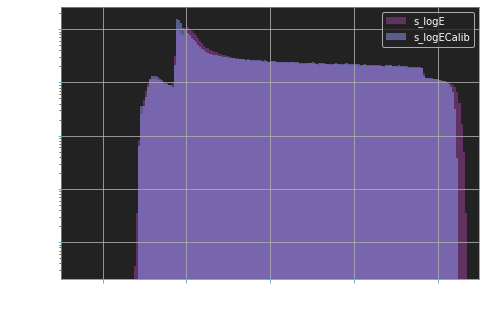

In [13]:
# Let's make a histogram of the regression vars, before scaling.
fig, ax = plt.subplots(1,1,figsize=(7.5,5))
labels = ['s_logE','s_logECalib']
rvars = [np.concatenate([frame[x].to_numpy() for frame in data_frames.values()]) for x in labels]

pu.histogramOverlay(ax, rvars, labels, 'x', 'y',
                 x_min = -2.5, x_max = 2.5, xbins = 200,
                 normed = True, y_log = True,
                 ps = qu.PlotStyle('dark')
                )
plt.show()

In [14]:
# now we save our scalers to a file, so that we can use them when evaluating the model elsewhere
# TODO: consider avoiding overwriting of scalers
scalers = {'e':scaler_e, 'cal':scaler_cal, 'eta':scaler_eta}
scaler_file = modelpath + 'scalers.save'
result = jl.dump(scalers,scaler_file)

We may optionally perform some re-weighting of our training events. If using the `pion_reweighted` strategy, we will re-weight our single-pion training data to match the topo-cluster $p_T$ spectrum of our jet data.

In [15]:
sample_weights = {}
if(strat == 'pion_reweighted'):
    pt_min = 0.
    pt_max = 20.
    pt_bins = 100
        
    # Get the jet files for reweighting. We look in jets/ to make sure we only use the relevant files.
    jet_files = glob.glob(path_prefix + 'jets/data/pion/*.root')
    
    for key in training_frames.keys():
        h_train    = rt.TH1F(qu.RN(), 'h_train',   pt_bins, pt_min, pt_max)
        h_reweight = rt.TH1F(qu.RN(), 'h_reweight',pt_bins, pt_min, pt_max)

        # fill training distribution
        training_vals = data_frames[key]['clusterPt'][training_indices[key]].to_numpy()
        for entry in training_vals: h_train.Fill(entry)
        h_train.Scale(1./h_train.Integral())
        
        # fill the reweighting distribution
        for file in jet_files:
            for entry in ur.open(file)['ClusterTree'].array('clusterPt').flatten():
                h_reweight.Fill(entry)
        h_reweight.Scale(1./h_reweight.Integral())
        h_reweight = h_reweight / h_train
        
        # now get a list of weights for our events
        sample_weights[key] = np.array([h_reweight.GetBinContent(h_reweight.FindBin(x)) for x in training_vals])
    
#else:  sample_weights = {key:np.full(len(All_input[key]), 1.) for key in All_input.keys()}
    
else:  sample_weights = {key:np.full(int(np.sum(training_indices[key])), 1.) for key in training_indices.keys()}

## Tensorflow/Keras Prep

In this workflow we have the ability to train a number of models -- some will require additional data setup. Here, we have some basic setup they will all use.

In [16]:
models = {} # keep track of the models -- note that we train multiple instances of each model
histories = {} # keep track of histories of the models we train
regressors = {} # keep track of the trained models (will be KerasRegressor objects)
energy_names = {} # keep track of the names of regressed variables

model_filename_suffixes = {
    'pp':'_charged',
    'p0':'_neutral'
}

energy_name_prefix = 'clusterE_pred_'

from keras.wrappers.scikit_learn import KerasRegressor # scikit_learn wrapper -- why do we use this, vs. native tf.keras approach like in classification notebook?
from tensorflow.keras.models import load_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

from models import baseline_nn_All_model, simple_dnn, resnet
import training_utils as tu

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


Let's prepare the calorimeter images already, as a number of different networks will use them as part of the input.

In [17]:
calo_images = tu.LoadCaloImages(data_trees, data_indices, layers)

Loading calo images:       |██████████████████████████████████████████████████| 100.0% Complete


Let's also make some simple functions to neatly define callbacks.

In [ ]:
def Checkpoint(modelfile, monitor='val_loss', save_best_only=False,save_freq='epoch'):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=modelfile,
        monitor=monitor,
        verbose=0,
        save_best_only=save_best_only,
        save_weights_only=False,
        mode='auto',
        save_freq=save_freq
    )

def CyclicLearningRate(base_lr, max_lr, step_size=2.0e3, mode='triangular2',gamma=1., scale_fn=None, scale_mode='cycle'):
    return clr.clr(
        base_lr=base_lr, 
        max_lr=max_lr, 
        step_size=step_size, 
        mode=mode,
        gamma=gamma, 
        scale_fn=scale_fn, 
        scale_mode=scale_mode
    )

## ResNet

We can also train an implementation of ResNet. More precisely, we use a ResNet model on the calorimeter images, and then mix in the energy and $\eta$ at the output layer.

In [19]:
# ResNet
model_key = 'resnet'
energy_names[model_key] = energy_name_prefix + model_key
lr = 1e-6 # 5e-5 by default
max_lr = 5e-5
channels = 6
filter_sets = [
    [64,64,256],
    [128,128,512]
    #[256,256,1024]
    #[512,512,2048]
]         
f_vals = [3,3] # [3,3,3,3] sizes of filters in middle of conv/identity blocks
s_vals = [1,2] # [1,2,2,2] strides for each convolutional block
i_vals = [2,3] # [2,3,5,2] number of identity blocks per stage
input_shape = (128,16)
augmentation = True # whether or not to augment data during training, by flipping in eta & phi
energy_in = True # whether or not to use reco energy as an explicit input (otherwise try to use image integrals, which doesn't work well)
models[model_key] = resnet(strategy, 
                           lr=lr, 
                           channels=channels, 
                           filter_sets=filter_sets, 
                           f_vals=f_vals, 
                           s_vals=s_vals, 
                           i_vals=i_vals, 
                           input_shape=input_shape, 
                           augmentation=augmentation,
                           energy_in=energy_in
                          )

# Define our regressors (actual networks) that we will fit (train).
batch_size = 20 * ngpu
epochs = 100 # 20
verbose = 1
regressors[model_key] = {key: KerasRegressor(build_fn=models[model_key], batch_size=batch_size, epochs=epochs, verbose=verbose) for key in training_indices.keys()}
histories[model_key] = {}

# Prepare the data.
All_input = tu.ResnetInput(data_frames, data_trees, data_indices, layers, cell_shapes, calo_images=calo_images)
Split_input = tu.DictionarySplit(All_input, training_indices, validation_indices)
train_input = Split_input['train']
valid_input = Split_input['valid']

for key in train_input.keys():
    tidx = training_indices[key]
    vidx = validation_indices[key]
    
    loadModel = False
    saveModel = True
    model_dir = ''.join([modelpath, model_key])
    model_filename = '{}/{}{}.h5'.format(model_dir,model_key,model_filename_suffixes[key])
    if(pathlib.Path(model_filename).exists() and not overwriteModel): 
        loadModel = True
        saveModel = False
    
    callbacks = [
        Checkpoint(model_filename),
        CyclicLearningRate(base_lr=lr, max_lr=max_lr, step_size=4. * np.sum(training_indices[key])/batch_size)
    ]
            
    history = tu.PrepNetwork(
        regressor=regressors[model_key][key],
        modelfile=model_filename,
        loadModel=loadModel,
        x_train = train_input[key],
        y_train = data_frames[key]['s_logECalib'][tidx],
        x_valid = valid_input[key],
        y_valid = data_frames[key]['s_logECalib'][vidx],
        sample_weight=sample_weights[key],
        saveModel=saveModel,
        callbacks=callbacks
    )
    histories[model_key][key] = history
    # Get predictions for all the data.
    data_frames[key][energy_names[model_key]] = EnergyMapping.Inverse(scaler_cal[key].inverse_transform(regressors[model_key][key].predict(All_input[key])))

     Loading model at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion//resnet/resnet_charged.h5.
   Loading history at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion//resnet/resnet_charged.history.
43688/43688 [==============================] - 608s 14ms/step
     Loading model at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion//resnet/resnet_neutral.h5.
   Loading history at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion//resnet/resnet_neutral.history.
13209/13209 [==============================] - 182s 14ms/step


## Plotting results (testing how well our network works)

Now, let's plot some kinematics and network results. We'll make two groups of plots -- one for charged pions and one for neutral pions.

Within each group of plots, we'll make two plots for each quantity -- one made using just the training data, and then one made using all the data (training + whatever we excluded -- but still excluding events with `cluster_ENG_CALIB_TOT` $< 0$ since these blow up network output).

In [20]:
# for convenience below
training_frames = {key:frame[training_indices[key]] for key,frame in data_frames.items()}
validation_frames = {key:frame[validation_indices[key]] for key,frame in data_frames.items()}

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/resnet_pp_plots.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/resnet_p0_plots.png has been created


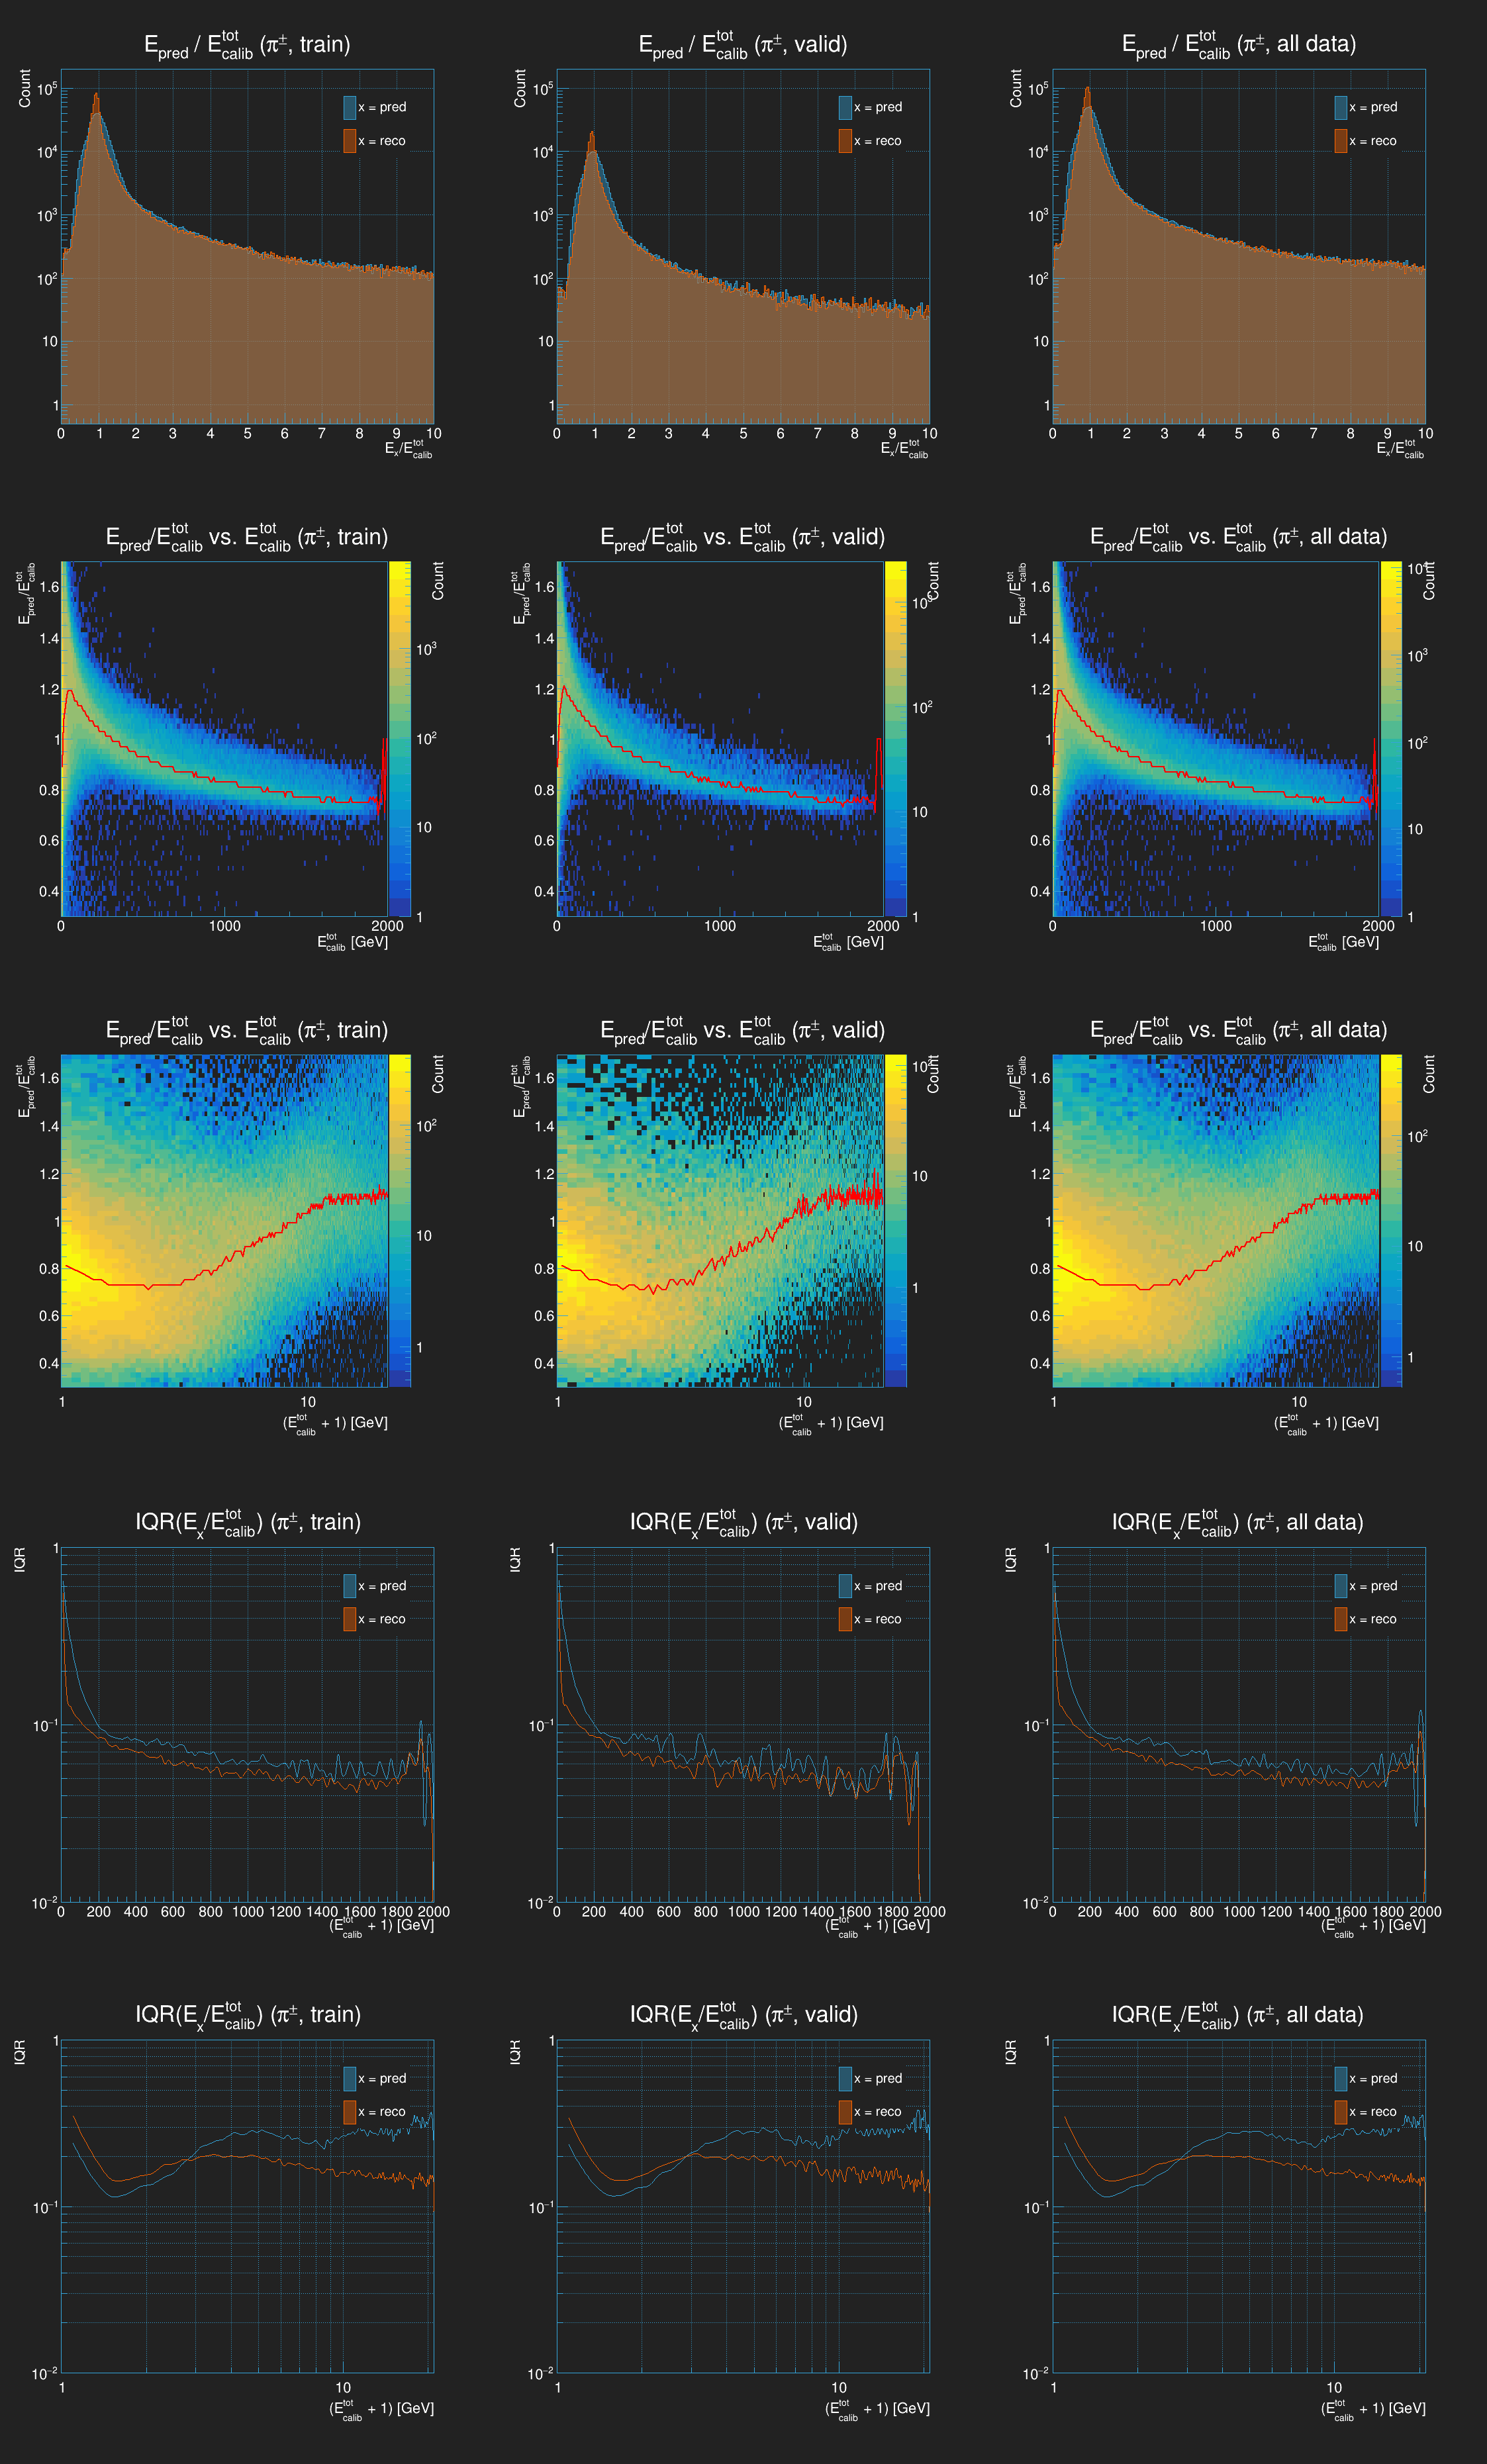

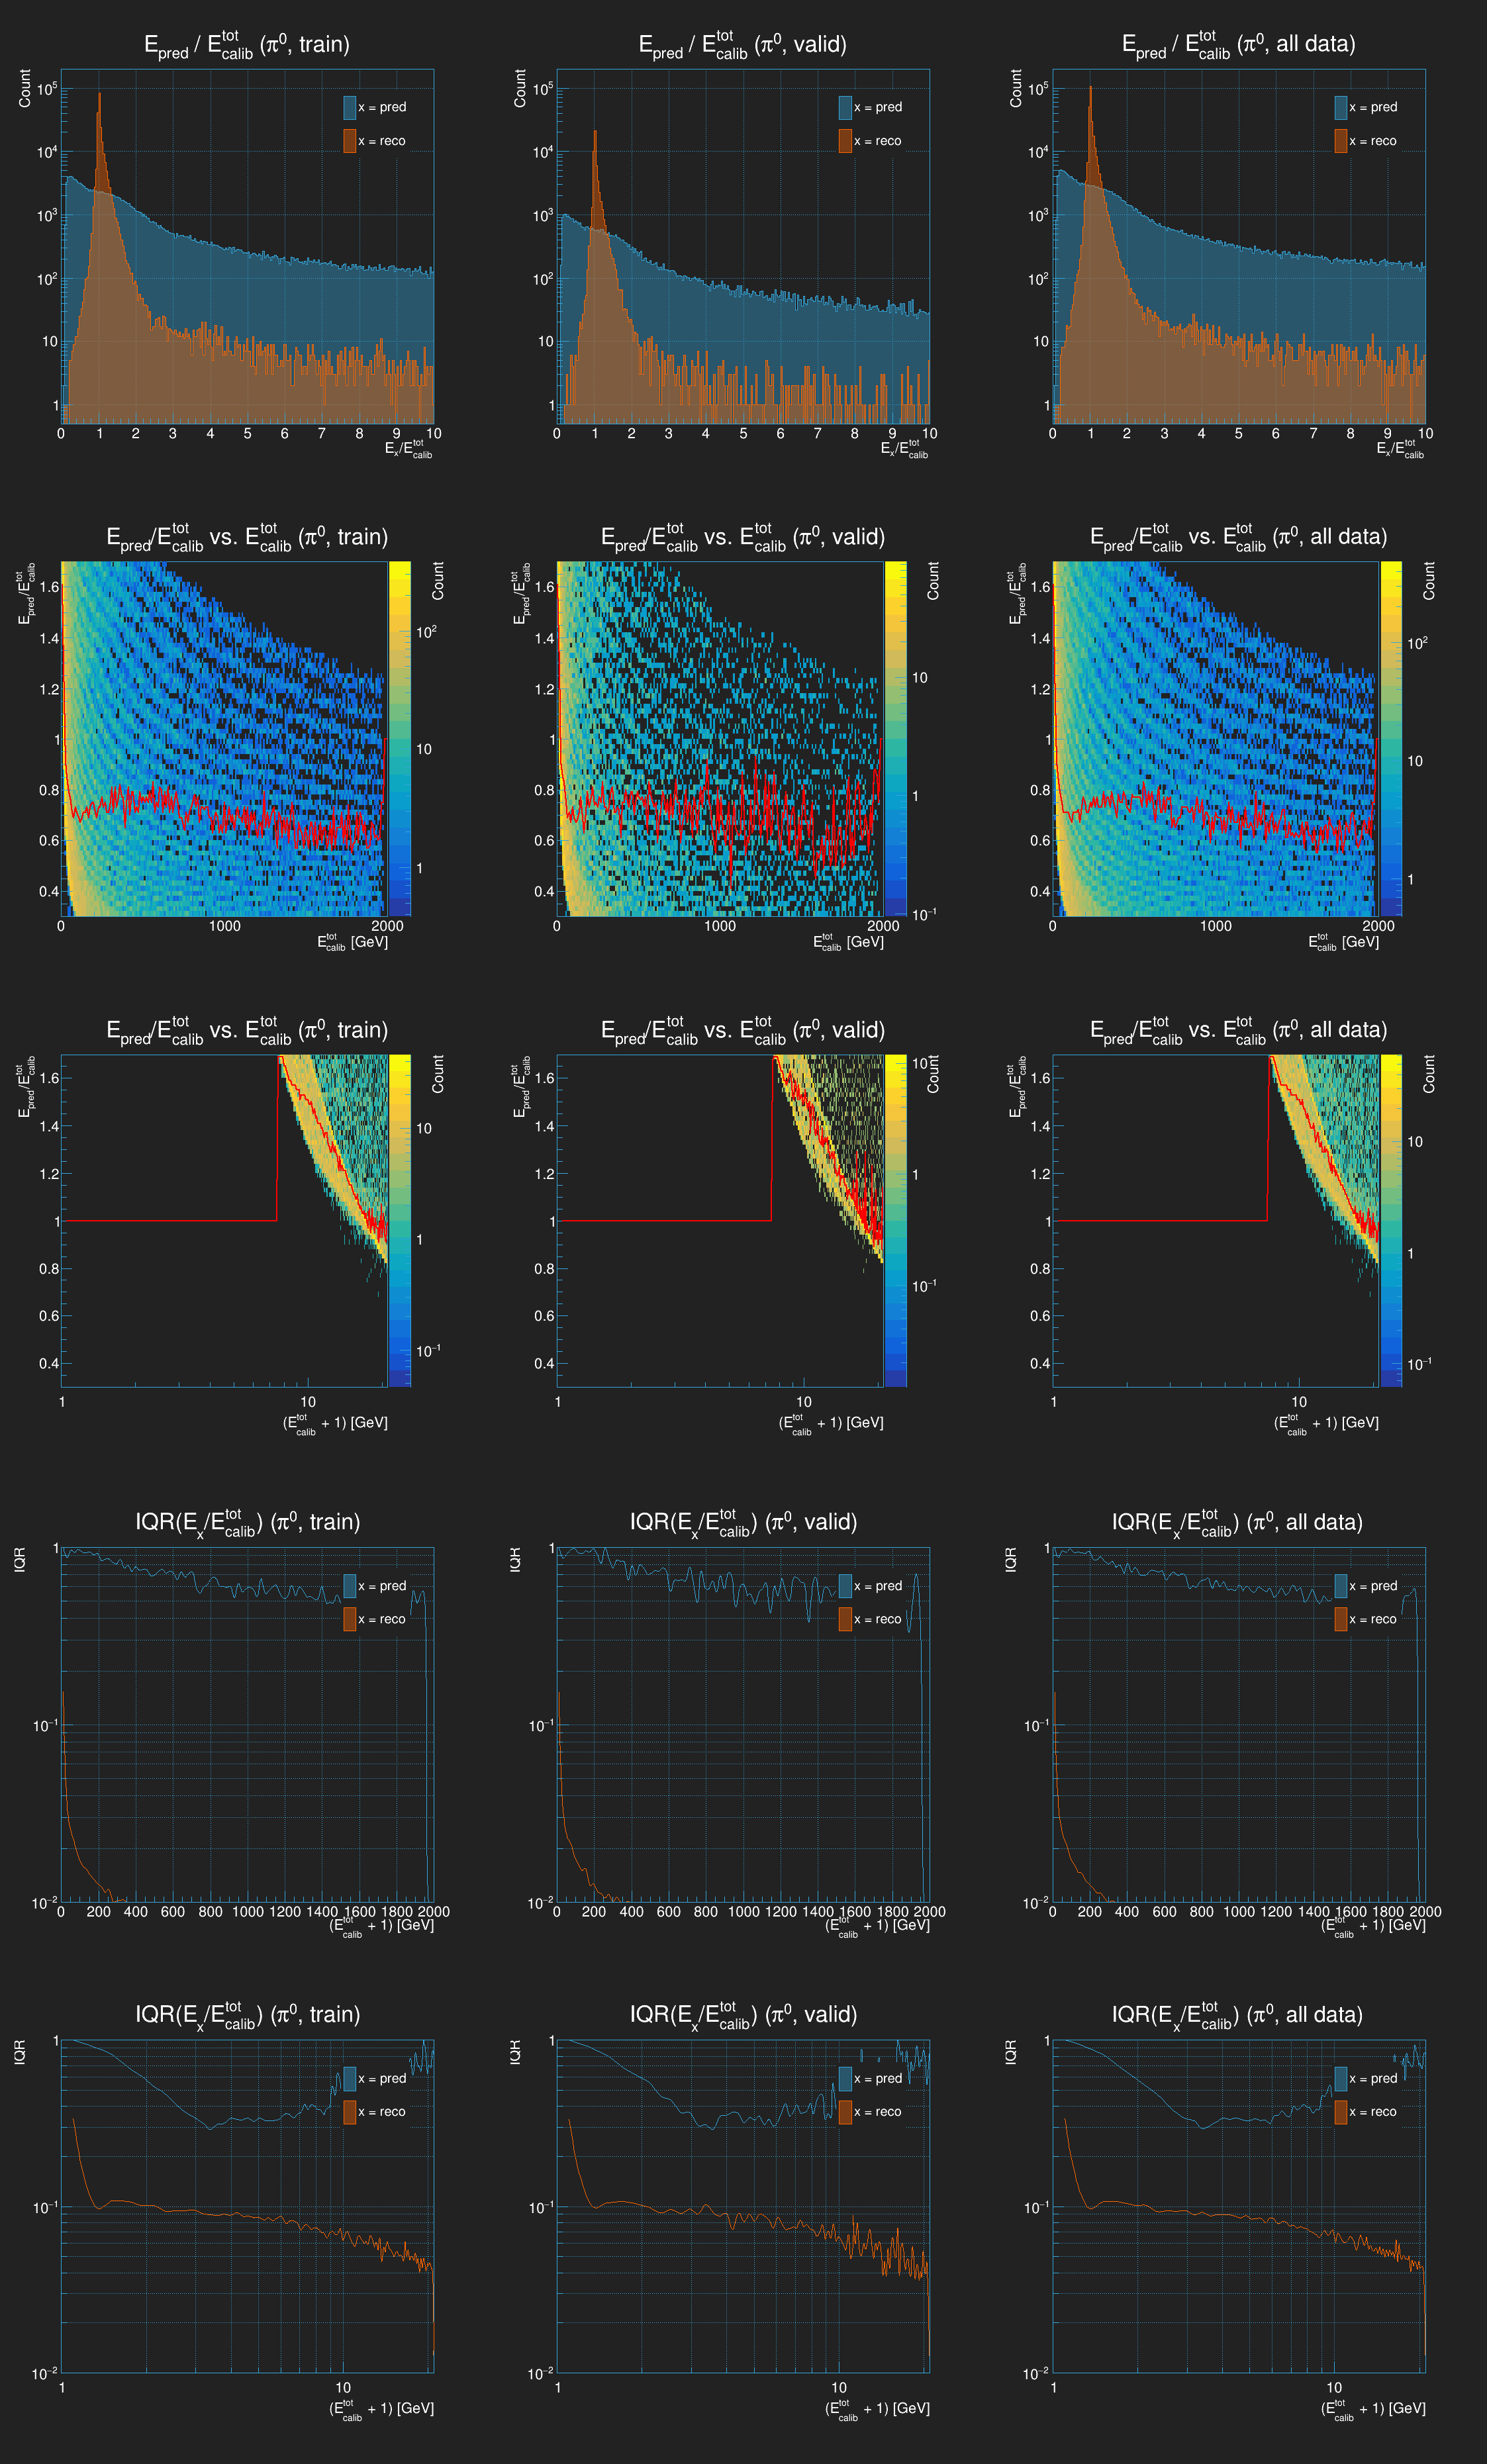

In [21]:
from plotting_utils import EnergySummary

for model_key in energy_names.keys():
    results = EnergySummary(
        train_dfs=training_frames, 
        valid_dfs=validation_frames, 
        data_dfs=data_frames, 
        energy_name=energy_names[model_key], 
        model_name=model_key, 
        plotpath=plotpath, 
        extensions=['png'], 
        plot_size=750, 
        strat='pion', 
        full=False,
        ps=plotstyle
    )
    for canv in results['canv'].values(): canv.Draw()

In [22]:
# Making graphs of the network models
from tensorflow.keras.utils import plot_model

for model_key in regressors.keys():
    for key,reg in regressors[model_key].items():
        graph_name = '{}{}_{}.png'.format(plotpath,model_key,key)
        plot_model(reg.model, graph_name, show_shapes=True, rankdir='LR', dpi=400)

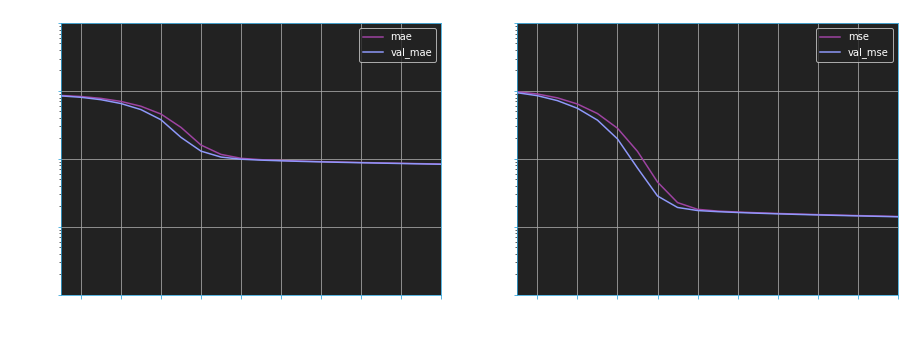

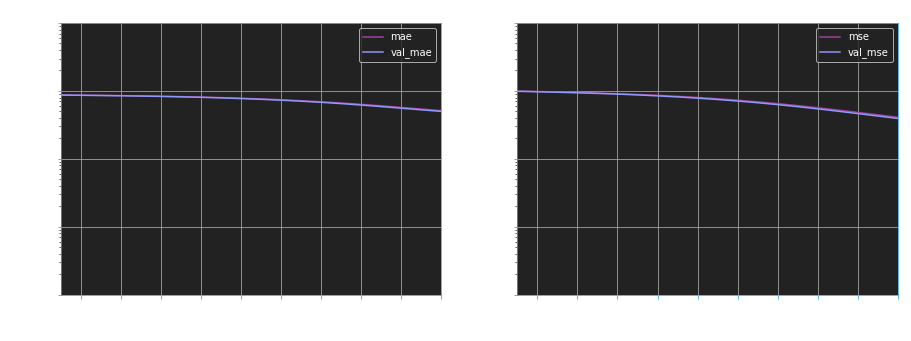

In [23]:
# Make plots of mse and mae for training and validation (if present)

for model_key in histories.keys():
    for dkey in histories[model_key].keys():
    
        dname = key_conversion[dkey]
        
        epochs = len(histories[model_key][dkey]['mae'])
        epoch_ticks = epochs
        if(epoch_ticks > 10): epoch_ticks = epoch_ticks/2
        x = np.arange(epochs) + 1
        fig, ax = plt.subplots(1,2,figsize=(15,5))
    
        keys = ['mae','val_mae']
        lines = [histories[model_key][dkey][key] for key in keys]
        pu.multiplot_common(ax[0], x,lines, keys, y_min=1.0e-3, y_max=10., y_log=True, x_ticks=epoch_ticks, xlabel = 'Epoch', ylabel = 'MAE', title='Mean Avg. Error for {} ({})'.format(model_key,dname), ps=plotstyle)
    
        keys = ['mse','val_mse']
        lines = [histories[model_key][dkey][key] for key in keys]
        pu.multiplot_common(ax[1], x,lines, keys, y_min=1.0e-3, y_max=10., y_log=True, x_ticks=epoch_ticks, xlabel = 'Epoch', ylabel = 'MSE', title='Mean Sq. Error for {} ({})'.format(model_key,dname), ps=plotstyle)
    
        # add grids
        for axis in ax.flatten():
            axis.grid(True,color=plotstyle.grid_plt)

        qu.SaveSubplots(fig, ax, ['mae_{}_{}'.format(model_key,dkey), 'mse_{}_{}'.format(model_key,dkey)], savedir=plotpath)
        plt.show()